**1.Import Libraries and Input data**

In [40]:
#loading the unprocessed data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import string
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import GaussianNB
import os
nltk.download('vader_lexicon')
project_data = pd.read_excel('Appliances_Postings_for_AUD.xlsx')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
#droping irrelevant columns
project_data = project_data.drop(['link','Title','Price','Make'], axis=1)
project_data


,Posting ID,Description,Condition
0,0,Frigidaire Black Built-in Oven Excellent hardl...,like new
1,1,Whirlpool Top load WasherNot pretty but works ...,like new
2,2,Maytag Top Loading WasherA little older and no...,like new
3,3,Kenmore Stainless Steel RangeGently Used Condi...,like new
4,4,Whirlpool Black Side by Side Fridge!Excellent ...,like new
...,...,...,...
5395,5395,Vintage Canister Vacuum Cleaner - automatic co...,good
5396,5396,Like new. Very little use in Capitola medical ...,NaN
5397,5397,Brand new in the box,new
5398,5398,SPT Counter/ mobile dishwasher Open box excell...,like new


**2. Data Exploration**

In [42]:
#Exploring at project_data dataframe
num_of_colmns_proj = len(project_data.columns)
num_of_rows_proj   = len(project_data)
print('Number of Columns in Project data   : ',num_of_colmns_proj)
print('Number of rows in Project data      : ',num_of_rows_proj)

Number of Columns in Project data   :  3
Number of rows in Project data      :  5400


In [43]:
#defining the function to calculate the length of the string, number of words, and presence of digit in each text field
import regex as re
def check_len(summary):
  size = len(summary)
  return size

def check_word_count(summary):
  countt=0
  for word in summary.split(' '):
    countt+=1
  return countt

def digit_counter(summary):
  temp = bool(re.search('\d',summary))
  if temp:
    return 1
  else:
    return 0


In [44]:
#introducing new columns to denote the length of project summary and number of words in it
project_data['summary_size']     = project_data.apply(lambda x: check_len(str(x['Description'])),axis=1)
project_data['words_in_summary'] = project_data.apply(lambda x: check_word_count(str(x['Description'])),axis=1)
project_data['digit_in_summary'] = project_data.apply(lambda x: digit_counter(str(x['Description'])),axis=1)
project_data.head(6)


,Posting ID,Description,Condition,summary_size,words_in_summary,digit_in_summary
0,0,Frigidaire Black Built-in Oven Excellent hardl...,like new,266,45,1
1,1,Whirlpool Top load WasherNot pretty but works ...,like new,184,34,1
2,2,Maytag Top Loading WasherA little older and no...,like new,335,62,1
3,3,Kenmore Stainless Steel RangeGently Used Condi...,like new,257,39,1
4,4,Whirlpool Black Side by Side Fridge!Excellent ...,like new,252,40,1
5,5,ZLine Gas StoveThis is NEWover $1k off!5 burne...,new,202,35,1


In [45]:
#understanding the variation in the length of summary and number of words in it
summ_max = project_data['summary_size'].max()
summ_min = project_data['summary_size'].min()

print('Maximum lenth of summary is  : ',summ_max)
print('Minimum lenth of summary is  : ',summ_min)


Maximum lenth of summary is  :  28223
Minimum lenth of summary is  :  1


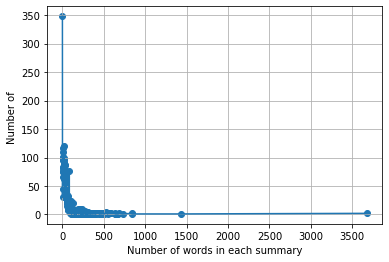

In [46]:

#understanding the variation in number of words in summary
from collections import Counter
summ_word_counter    = Counter()
word_count_summ      = list(project_data['words_in_summary'])
summ_word_counter.update(word_count_summ)
summ_word_counter    = dict(summ_word_counter)
summ_word_counter    = dict(sorted(summ_word_counter.items(), key=lambda kv: kv[0]))
plt.plot(list(summ_word_counter.keys()),list(summ_word_counter.values()))
plt.scatter(list(summ_word_counter.keys()),list(summ_word_counter.values()))
plt.xlabel('Number of words in each summary')
plt.ylabel('Number of ')
plt.grid()
plt.show()


In [47]:

#variation in our class label
project_data['Condition'].value_counts()


new          1194
excellent    1034
good          615
like new      582
fair           49
salvage        16
Name: Condition, dtype: int64

**3. Text Preprocessing & Feature Extraction**

In [48]:
#Preprocessing the Description column
import re
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


     

#creating a list of stop words
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [49]:
#using above functions and list of stop words to preprocess the textual data
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    for sentance in tqdm(text_data):
        sentance = str(sentance)
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text


In [50]:
#preprocessing the project title using above defined functions
cleaned_Description = preprocess_text(project_data['Description'].values)



#creating a new column with preprocessed Description
project_data['cleaned_Description'] = np.array(cleaned_Description)
project_data


100%|██████████| 5400/5400 [00:01<00:00, 4575.74it/s]


,Posting ID,Description,Condition,summary_size,words_in_summary,digit_in_summary,cleaned_Description
0,0,Frigidaire Black Built-in Oven Excellent hardl...,like new,266,45,1,frigidaire black built oven excellent hardly u...
1,1,Whirlpool Top load WasherNot pretty but works ...,like new,184,34,1,whirlpool top load washernot pretty works like...
2,2,Maytag Top Loading WasherA little older and no...,like new,335,62,1,maytag top loading washera little older not su...
3,3,Kenmore Stainless Steel RangeGently Used Condi...,like new,257,39,1,kenmore stainless steel rangegently used condi...
4,4,Whirlpool Black Side by Side Fridge!Excellent ...,like new,252,40,1,whirlpool black side side fridge excellent har...
...,...,...,...,...,...,...,...
5395,5395,Vintage Canister Vacuum Cleaner - automatic co...,good,182,31,1,vintage canister vacuum cleaner automatic cord...
5396,5396,Like new. Very little use in Capitola medical ...,NaN,89,15,1,like new little use capitola medical office si...
5397,5397,Brand new in the box,new,20,5,0,brand new box
5398,5398,SPT Counter/ mobile dishwasher Open box excell...,like new,129,20,0,spt counter mobile dishwasher open box excelle...


In [51]:
#Generating the word cloud data for New and Excellent
Excellent_description = list(project_data[project_data['Condition'] == 'excellent']['cleaned_Description'].values)
Excellent_description_str = ''
for doc in Excellent_description:
    Excellent_description_str += doc


new_description = list(project_data[project_data['Condition'] == 'new']['cleaned_Description'].values)
new_description_str = ''
for doc in new_description:
    new_description_str += doc


cat_1 = Excellent_description_str + ' ' + new_description_str



Excellent_description = list(project_data[project_data['Condition'] == 'excellent']['cleaned_Description'].values)

Excellent_description_str = ''
for doc in Excellent_description:
    Excellent_description_str += doc


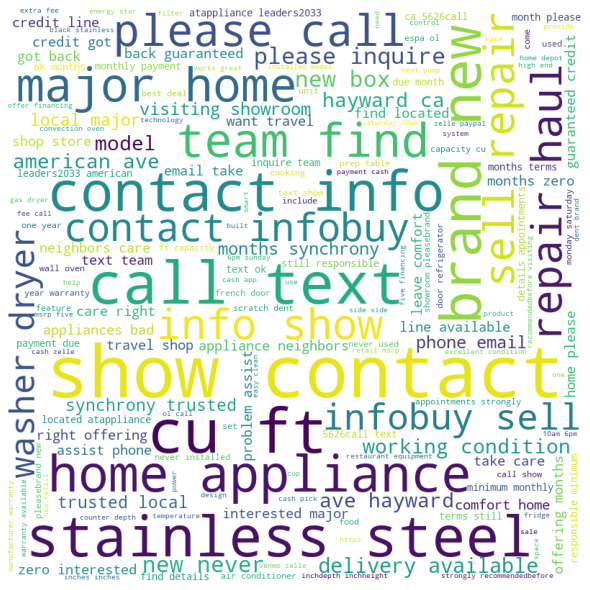

In [52]:
#generating a word cloud using word cloud library
Word_box_pre = cat_1
from wordcloud import WordCloud, STOPWORDS
#STOPWORDS.add('new')
#STOPWORDS.add('box')
#STOPWORDS.add('will')
wordcloud = WordCloud(width = 800,height = 800,background_color ='white',min_font_size=10, stopwords=STOPWORDS).generate(str(Word_box_pre))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [53]:
#Generating the word cloud data for Good and New
Good_description = list(project_data[project_data['Condition'] == 'good']['cleaned_Description'].values)
Good_description_str = ''
for doc in Good_description:
    Good_description_str += doc


like_new_description = list(project_data[project_data['Condition'] == 'like new']['cleaned_Description'].values)
like_new_description_str = ''
for doc in new_description:
    like_new_description_str += doc


fair_description = list(project_data[project_data['Condition'] == 'fair']['cleaned_Description'].values)
fair_description_str = ''
for doc in fair_description:
    fair_description_str += doc


cat_2 = Good_description_str + ' ' + like_new_description_str + ' ' + fair_description_str

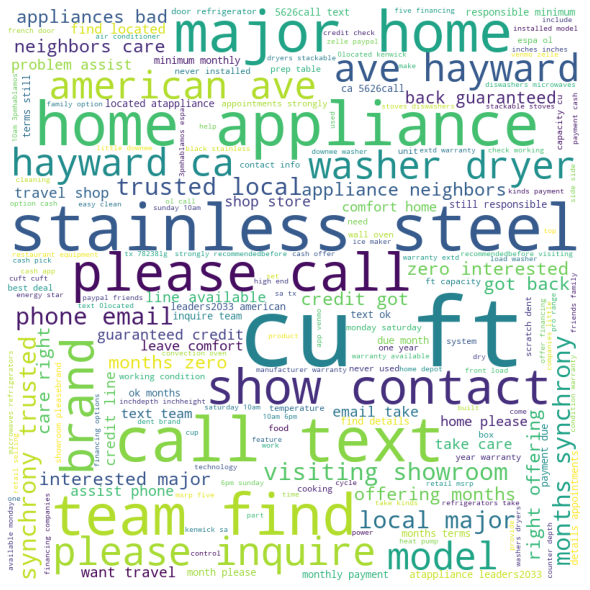

In [54]:
#generating a word cloud using word cloud library
Word_box_pre = cat_2
from wordcloud import WordCloud, STOPWORDS
STOPWORDS.add('new')
#STOPWORDS.add('box')
#STOPWORDS.add('will')
wordcloud = WordCloud(width = 800,height = 800,background_color ='white',min_font_size=10, stopwords=STOPWORDS).generate(Word_box_pre)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


4. **Generating Sentiment scores and flags based on decscriptions**

In [55]:
#Generating sentiment scores for the cleaned descriptions
sid = SentimentIntensityAnalyzer()
project_data['positive_sentiments'] = project_data.apply(lambda x: sid.polarity_scores(str(x['cleaned_Description']))['pos'],axis=1)
project_data


,Posting ID,Description,Condition,summary_size,words_in_summary,digit_in_summary,cleaned_Description,positive_sentiments
0,0,Frigidaire Black Built-in Oven Excellent hardl...,like new,266,45,1,frigidaire black built oven excellent hardly u...,0.243
1,1,Whirlpool Top load WasherNot pretty but works ...,like new,184,34,1,whirlpool top load washernot pretty works like...,0.434
2,2,Maytag Top Loading WasherA little older and no...,like new,335,62,1,maytag top loading washera little older not su...,0.281
3,3,Kenmore Stainless Steel RangeGently Used Condi...,like new,257,39,1,kenmore stainless steel rangegently used condi...,0.177
4,4,Whirlpool Black Side by Side Fridge!Excellent ...,like new,252,40,1,whirlpool black side side fridge excellent har...,0.254
...,...,...,...,...,...,...,...,...
5395,5395,Vintage Canister Vacuum Cleaner - automatic co...,good,182,31,1,vintage canister vacuum cleaner automatic cord...,0.165
5396,5396,Like new. Very little use in Capitola medical ...,NaN,89,15,1,like new little use capitola medical office si...,0.172
5397,5397,Brand new in the box,new,20,5,0,brand new box,0.000
5398,5398,SPT Counter/ mobile dishwasher Open box excell...,like new,129,20,0,spt counter mobile dishwasher open box excelle...,0.363


In [56]:

#dropping rows with no decription
project_data = project_data[project_data['Description'].notna()]
nan_rows = project_data[project_data['Description'].isnull()]
nan_rows



,Posting ID,Description,Condition,summary_size,words_in_summary,digit_in_summary,cleaned_Description,positive_sentiments


In [57]:
#adding flag attributes to the data set
project_data['ex_flag'] = project_data['Description'].str.contains('excellent|Excellent').astype(int)
project_data['new_flag'] = project_data['Description'].str.contains('new|New').astype(int)
project_data['go_flag'] = project_data['Description'].str.contains('good|Good').astype(int)

<ipython-input-57-32bb0e1aa996>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['ex_flag'] = project_data['Description'].str.contains('excellent|Excellent').astype(int)
<ipython-input-57-32bb0e1aa996>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['new_flag'] = project_data['Description'].str.contains('new|New').astype(int)
<ipython-input-57-32bb0e1aa996>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [58]:
#Test data to generate final predictions
For_test = project_data[project_data['Condition'].isnull()]
For_test


,Posting ID,Description,Condition,summary_size,words_in_summary,digit_in_summary,cleaned_Description,positive_sentiments,ex_flag,new_flag,go_flag
8,8,12 cup food processor by Hamilton beach. used...,NaN,109,24,1,12 cup food processor hamilton beach used 2 3 ...,0.000,0,0,0
11,11,Clean and in good working condition,NaN,35,6,0,clean good working condition,0.737,0,0,1
14,14,Air conditioning heating appliance repair heat...,NaN,406,53,1,air conditioning heating appliance repair heat...,0.189,0,1,0
15,15,5 door stainless steel refrigeratorRetails $51...,NaN,92,9,1,5 door stainless steel refrigeratorretails 510...,0.000,0,0,0
16,16,Front load kenmore washer and and front load k...,NaN,172,28,0,front load kenmore washer front load kenmore d...,0.268,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5384,5384,Electrolux Part Number: 318193800Control Panel...,NaN,220,24,1,electrolux part number 318193800control panel ...,0.046,0,0,0
5385,5385,You are looking at : Touch single serve brewin...,NaN,119,21,1,looking touch single serve brewing system coff...,0.000,0,0,0
5387,5387,GE 3 in 1 air conditioner new in the box never...,NaN,85,19,1,ge 3 1 air conditioner new box never opened go...,0.000,0,1,0
5391,5391,"Brand New, box openedSee here for product deta...",NaN,375,12,1,brand new box openedsee product details https ...,0.000,0,1,0


In [59]:
#variation in our target label
project_data['Condition'].value_counts()


new          1194
excellent    1034
good          615
like new      582
fair           49
salvage        16
Name: Condition, dtype: int64

In [60]:
#mapping column values with digits based on assumption
project_data['Condition'] = project_data['Condition'].map({'excellent': 0, 'new': 0, 'good':1, 'like new':1, 'fair':1 })

<ipython-input-60-87cce94ebd33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['Condition'] = project_data['Condition'].map({'excellent': 0, 'new': 0, 'good':1, 'like new':1, 'fair':1 })


In [61]:
#variation in our class label now
project_data['Condition'].value_counts()

0.0    2228
1.0    1246
Name: Condition, dtype: int64

In [62]:
#dropping rows with Nan coondition
project_data.dropna(subset=['Condition'],inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [63]:
#partioning columns as per the nature of metadata
y = project_data['Condition'].values
X = project_data.drop(['Description','Condition'], axis=1)


In [64]:
#viewing data that should be processed
X.head(3)

,Posting ID,summary_size,words_in_summary,digit_in_summary,cleaned_Description,positive_sentiments,ex_flag,new_flag,go_flag
0,0,266,45,1,frigidaire black built oven excellent hardly u...,0.243,1,0,0
1,1,184,34,1,whirlpool top load washernot pretty works like...,0.434,0,0,0
2,2,335,62,1,maytag top loading washera little older not su...,0.281,0,0,1


**5. Train & CV split**

In [65]:
#spliting the entire data into train and test, then further train data into train and cross validate
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y)

In [66]:

#getting data for our testing
y_test = For_test['Condition'].values
X_test = For_test.drop(['Description','Condition'], axis=1)
X_test.head(3)


,Posting ID,summary_size,words_in_summary,digit_in_summary,cleaned_Description,positive_sentiments,ex_flag,new_flag,go_flag
8,8,109,24,1,12 cup food processor hamilton beach used 2 3 ...,0.000,0,0,0
11,11,35,6,0,clean good working condition,0.737,0,0,1
14,14,406,53,1,air conditioning heating appliance repair heat...,0.189,0,1,0


In [67]:

#creating a big list of all the features through train data
big_list_features = []


In [68]:
#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['go_flag'].values.reshape(-1,1))
big_list_features.extend(['go_flag'])


In [69]:

#using fitted Normalizer
X_train_go_flag_norm = normalizer.transform(X_train['go_flag'].values.reshape(-1,1))
X_cv_go_flag_norm = normalizer.transform(X_cv['go_flag'].values.reshape(-1,1))
X_test_go_flag_norm = normalizer.transform(X_test['go_flag'].values.reshape(-1,1))

In [70]:
#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_go_flag_norm.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_train_go_flag_norm.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_train_go_flag_norm.shape,'Y test  shape :', y_test.shape)


Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (2779, 1) Y C.V.  shape : (695,)
Test  vector shape :  (2779, 1) Y test  shape : (1570,)


In [71]:
#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['new_flag'].values.reshape(-1,1))
big_list_features.extend(['new_flag'])


In [73]:
#using fitted Normalizer
X_train_new_flag_norm = normalizer.transform(X_train['new_flag'].values.reshape(-1,1))
X_cv_new_flag_norm = normalizer.transform(X_cv['new_flag'].values.reshape(-1,1))
X_test_new_flag_norm = normalizer.transform(X_test['new_flag'].values.reshape(-1,1))

In [74]:
#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_new_flag_norm.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_new_flag_norm.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_new_flag_norm.shape,'Y test  shape :', y_test.shape)


Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [43]:
#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['ex_flag'].values.reshape(-1,1))
big_list_features.extend(['ex_flag'])

In [75]:
#using fitted Normalizer
X_train_ex_flag_norm = normalizer.transform(X_train['ex_flag'].values.reshape(-1,1))
X_cv_ex_flag_norm = normalizer.transform(X_cv['ex_flag'].values.reshape(-1,1))
X_test_ex_flag_norm = normalizer.transform(X_test['ex_flag'].values.reshape(-1,1))

In [76]:

#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_ex_flag_norm.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_ex_flag_norm.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_ex_flag_norm.shape,'Y test  shape :', y_test.shape)


Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [77]:

#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['digit_in_summary'].values.reshape(-1,1))
big_list_features.extend(['digit_in_summary'])


In [78]:

#using fitted Normalizer
X_train_digit_in_summary_norm = normalizer.transform(X_train['digit_in_summary'].values.reshape(-1,1))
X_cv_digit_in_summary_norm = normalizer.transform(X_cv['digit_in_summary'].values.reshape(-1,1))
X_test_digit_in_summary_norm = normalizer.transform(X_test['digit_in_summary'].values.reshape(-1,1))


In [79]:

#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_digit_in_summary_norm.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_digit_in_summary_norm.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_digit_in_summary_norm.shape,'Y test  shape :', y_test.shape)


Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [80]:

#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['words_in_summary'].values.reshape(-1,1))
big_list_features.extend(['words_in_summary'])


In [81]:
#using fitted Normalizer
X_train_words_in_summary = normalizer.transform(X_train['words_in_summary'].values.reshape(-1,1))
X_cv_words_in_summary = normalizer.transform(X_cv['words_in_summary'].values.reshape(-1,1))
X_test_words_in_summary = normalizer.transform(X_test['words_in_summary'].values.reshape(-1,1))

In [82]:
#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_words_in_summary.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_words_in_summary.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_words_in_summary.shape,'Y test  shape :', y_test.shape)

Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [83]:

#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['summary_size'].values.reshape(-1,1))
big_list_features.extend(['summary_size'])


In [84]:

#using fitted Normalizer
X_train_summary_size = normalizer.transform(X_train['summary_size'].values.reshape(-1,1))
X_cv_summary_size = normalizer.transform(X_cv['summary_size'].values.reshape(-1,1))
X_test_summary_size = normalizer.transform(X_test['summary_size'].values.reshape(-1,1))


In [85]:
#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_summary_size.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_summary_size.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_summary_size.shape,'Y test  shape :', y_test.shape)


Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [86]:

#fit vectorizing the column of train data using CountVectorizer
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['positive_sentiments'].values.reshape(-1,1))
big_list_features.extend(['positive_sentiments'])


In [87]:
#using fitted Normalizer
X_train_positive_sentiments = normalizer.transform(X_train['positive_sentiments'].values.reshape(-1,1))
X_cv_positive_sentiments = normalizer.transform(X_cv['positive_sentiments'].values.reshape(-1,1))
X_test_positive_sentiments = normalizer.transform(X_test['positive_sentiments'].values.reshape(-1,1))


In [88]:

#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_positive_sentiments.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_positive_sentiments.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_positive_sentiments.shape,'Y test  shape :', y_test.shape)

Train vector shape :  (2779, 1) Y train shape : (2779,)
C.V.  vector shape :  (695, 1) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 1) Y test  shape : (1570,)


In [89]:

#fit vectorizing the column of train data using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1,ngram_range=(1,1), max_features=5000) #Choosing the best after iteratively tuning across multiple representations
vectorizer.fit(X_train['cleaned_Description'].values)
print('Features on one hot encoding for the column :',len(vectorizer.get_feature_names()))
big_list_features.extend(vectorizer.get_feature_names())


Features on one hot encoding for the column : 5000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [90]:
#using fitted count vectorizer to convert text to vector
X_train_cleaned_cleaned_Description = vectorizer.transform(X_train['cleaned_Description'].values)
X_cv_cleaned_cleaned_Description = vectorizer.transform(X_cv['cleaned_Description'].values)
X_test_cleaned_cleaned_Description = vectorizer.transform(X_test['cleaned_Description'].values)

In [91]:

#printing the shape of vectors obtained post transformation and validating the number of rows using 'y'
print('Train vector shape : ',X_train_cleaned_cleaned_Description.shape,'Y train shape :',y_train.shape)
print('C.V.  vector shape : ',X_cv_cleaned_cleaned_Description.shape,'Y C.V.  shape :', y_cv.shape)
print('Test  vector shape : ',X_test_cleaned_cleaned_Description.shape,'Y test  shape :', y_test.shape)

Train vector shape :  (2779, 5000) Y train shape : (2779,)
C.V.  vector shape :  (695, 5000) Y C.V.  shape : (695,)
Test  vector shape :  (1570, 5000) Y test  shape : (1570,)


In [92]:
#concatinating features using hstack from scipy
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_ex_flag_norm, X_train_digit_in_summary_norm, X_train_cleaned_cleaned_Description,9*X_train_positive_sentiments)).tocsr()
X_cr_bow = hstack((X_cv_ex_flag_norm, X_cv_digit_in_summary_norm, X_cv_cleaned_cleaned_Description,9*X_cv_positive_sentiments)).tocsr()
X_te_bow = hstack((X_test_ex_flag_norm, X_test_digit_in_summary_norm, X_test_cleaned_cleaned_Description, 9*X_test_positive_sentiments)).tocsr()

In [93]:
#concatinating features using hstack from scipy
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_digit_in_summary_norm, X_train_cleaned_cleaned_Description,X_train_positive_sentiments)).tocsr()
X_cr_bow = hstack((X_cv_digit_in_summary_norm, X_cv_cleaned_cleaned_Description,X_cv_positive_sentiments)).tocsr()
X_te_bow = hstack((X_test_digit_in_summary_norm, X_test_cleaned_cleaned_Description, X_test_positive_sentiments)).tocsr()

In [94]:
#base case
from scipy.sparse import hstack
X_tr_bow = X_train_cleaned_cleaned_Description
X_cr_bow = X_cv_cleaned_cleaned_Description
X_te_bow = X_test_cleaned_cleaned_Description


In [95]:
#concatinating features using hstack from scipy
from scipy.sparse import hstack
X_tr_bow = hstack((9*X_train_ex_flag_norm, 3*X_train_new_flag_norm, X_train_go_flag_norm,X_train_digit_in_summary_norm,X_train_words_in_summary,X_train_summary_size,X_train_cleaned_cleaned_Description,X_train_positive_sentiments)).tocsr()
X_cr_bow = hstack((9*X_cv_ex_flag_norm, 3*X_cv_new_flag_norm, X_cv_go_flag_norm,X_cv_digit_in_summary_norm,X_cv_words_in_summary,X_cv_summary_size,X_cv_cleaned_cleaned_Description,X_cv_positive_sentiments)).tocsr()
X_te_bow = hstack((9*X_test_ex_flag_norm, 3*X_test_new_flag_norm, X_test_go_flag_norm,X_test_digit_in_summary_norm,X_test_words_in_summary,X_test_summary_size,X_test_cleaned_cleaned_Description, X_test_positive_sentiments)).tocsr()


In [96]:
#publishing the shape of final features
print(X_tr_bow.shape, y_train.shape)
print(X_cr_bow.shape, y_cv.shape)
print(X_te_bow.shape, y_test.shape)

(2779, 5007) (2779,)
(695, 5007) (695,)
(1570, 5007) (1570,)


In [97]:

#confirming with the dimension of our list of features
len(big_list_features)


5006

**5. Modeling using Count Vectorizer**

  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-99-bb1b63845646>:20: RuntimeWarning: overflow encountered in exp
  pred_probs = np.exp(y_train_pred)
<ipython-input-99-bb1b63845646>:25: RuntimeWarning: overflow encountered in exp
  pred_probs = np.exp(y_train_pred)
100%|██████████| 6/6 [00:42<00:00,  7.06s/it]


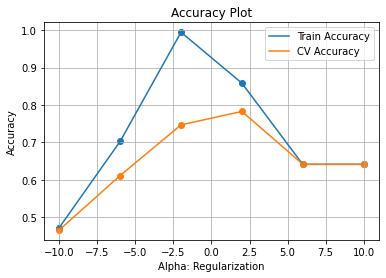

In [99]:
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_acc  = []
cv_acc     = []
train_val  = []
cv_val     = []
log_i      = []
roc = []
K = [10**-10,10**-6,10**-2,10**2, 10**6, 10**10]

for i in tqdm(K):
    Classifier = RidgeClassifier(alpha= i)
    Classifier.fit(X_tr_bow,y_train)
    y_train_pred = Classifier.decision_function(X_tr_bow)
    pred_probs = np.exp(y_train_pred)
    pred_probs = np.where(pred_probs>0.90, 1, 0)
    accuracy_val = accuracy_score(y_train, pred_probs)
    train_acc.append(accuracy_val)
    y_train_pred = Classifier.decision_function(X_cr_bow)
    pred_probs = np.exp(y_train_pred)
    pred_probs = np.where(pred_probs>0.90, 1, 0)
    accuracy_val = accuracy_score(y_cv, pred_probs)
    cv_acc.append(accuracy_val) 
    
for i in K:
    log_i.append(math.log10(i))
plt.plot(log_i, train_acc, label='Train Accuracy')
plt.plot(log_i, cv_acc, label='CV Accuracy')
plt.scatter(log_i, train_acc )
plt.scatter(log_i, cv_acc)
plt.legend()
plt.xlabel("Alpha: Regularization")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.grid()
plt.show()


100%|██████████| 6/6 [00:00<00:00, 112.32it/s]


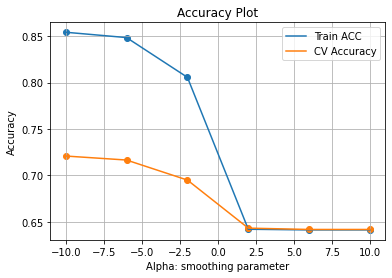

In [100]:
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_acc  = []
cv_acc     = []
train_val  = []
cv_val     = []
log_i      = []
roc=[]
#K = [10**-7,10**-6,10**-5,10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]

for i in tqdm(K):
    NB_Classifier = MultinomialNB(alpha = i)
    NB_Classifier.fit(X_tr_bow,y_train)
    y_train_pred     = NB_Classifier.predict(X_tr_bow)
    y_cv_pred        = NB_Classifier.predict(X_cr_bow)
    train_acc.append(accuracy_score(y_train,y_train_pred))
    cv_acc.append(accuracy_score(y_cv, y_cv_pred))
    roc.append(roc_auc_score(y_cv, y_cv_pred))
for i in K:
    log_i.append(math.log10(i))
plt.plot(log_i, train_acc, label='Train ACC')
plt.plot(log_i, cv_acc, label='CV Accuracy')
plt.scatter(log_i, train_acc)
plt.scatter(log_i, cv_acc)
plt.legend()
plt.xlabel("Alpha: smoothing parameter")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.grid()
plt.show()

100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


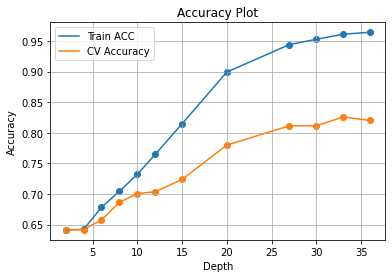

In [101]:
#applying the Random Forest Classifier on the prepared data set
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

train_acc  = []
cv_acc     = []
depth      = []
roc=[]
K = [2,4,6,8,10,12,15,20,27,30,33,36]

for i in tqdm(K):
    Rf_clf = RandomForestClassifier(max_depth=i, random_state=0)
    Rf_clf.fit(X_tr_bow,y_train)
    y_train_pred     = Rf_clf.predict(X_tr_bow)
    y_cv_pred        = Rf_clf.predict(X_cr_bow)
    train_acc.append(accuracy_score(y_train,y_train_pred))
    cv_acc.append(accuracy_score(y_cv, y_cv_pred))
    roc.append(roc_auc_score(y_cv, y_cv_pred))
for i in K:
    depth.append((i))
plt.plot(depth, train_acc, label='Train ACC')
plt.plot(depth, cv_acc, label='CV Accuracy')
plt.scatter(depth, train_acc )
plt.scatter(depth, cv_acc)
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.grid()
plt.show()

In [102]:
print('The max accuracy we are getting is',cv_acc[-2],'with depth of',K[-2],'are parameter for random forest')

The max accuracy we are getting is 0.8258992805755395 with depth of 33 are parameter for random forest


In [103]:
#Predicting and mapping the output
y_train_pred     = Rf_clf.predict(X_te_bow)
For_test['Condition'] = (y_train_pred)
For_test = For_test.astype({'Condition':'int'})
For_test['Condition'] = For_test['Condition'].map({ 0 : 'excellent',  1: 'good' })
For_test.to_csv('predictedcondition.csv')

<ipython-input-103-bb08f60397a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  For_test['Condition'] = (y_train_pred)


**End Of Part 1**



